[View in Colaboratory](https://colab.research.google.com/github/brynmwangy/predicting-bitcoin-prices-using-LSTM/blob/master/btc.ipynb)

Previsão de Preços do Bitcoin Usando Redes LSTM e Otimização de Parâmetros

Este projeto visa prever as variações no preço do Bitcoin utilizando uma abordagem sofisticada de modelagem de séries temporais: as redes neurais LSTM (Long Short-Term Memory). O Bitcoin, sendo uma das criptomoedas mais voláteis e amplamente discutidas, apresenta uma série de desafios e oportunidades quando se trata de previsão de preços. O estudo das suas flutuações pode oferecer insights não apenas para investidores, mas também para pesquisadores e entusiastas da área financeira.

Inicialmente, o projeto se concentra na preparação e transformação dos dados, criando uma estrutura sequencial adequada para a modelagem temporal. Em seguida, é desenvolvido um modelo LSTM no Keras, uma popular biblioteca de deep learning, e é empregada uma técnica de busca em grade (GridSearch) para otimizar seus parâmetros, garantindo assim a melhor performance possível. Uma vez treinado, o modelo é avaliado em conjunto de testes usando várias métricas de desempenho, como MSE, RMSE e Similaridade Cosseno. A etapa final visualiza as previsões do modelo em comparação com os dados reais, proporcionando uma análise visual intuitiva da eficácia do modelo em capturar as tendências do preço do Bitcoin ao longo do tempo.

Integrantes:
    Gabriel de Oliveira Sousa,
    Heitor,
    Matheus,
    Thiago

In [ ]:
#install all the required dependancy libraries
!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)


In [46]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [48]:
btc = pd.read_csv('btc.csv', encoding='utf-8').iloc[::-1]
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


In [49]:
#selecting only the column that we are going to use in the prediction process
data_to_use=btc['Close'].values
data_to_use

array([ 370.  ,  378.  ,  378.  , ..., 7584.15, 7459.11, 7520.  ])

In [50]:
print(len(data_to_use))

1273


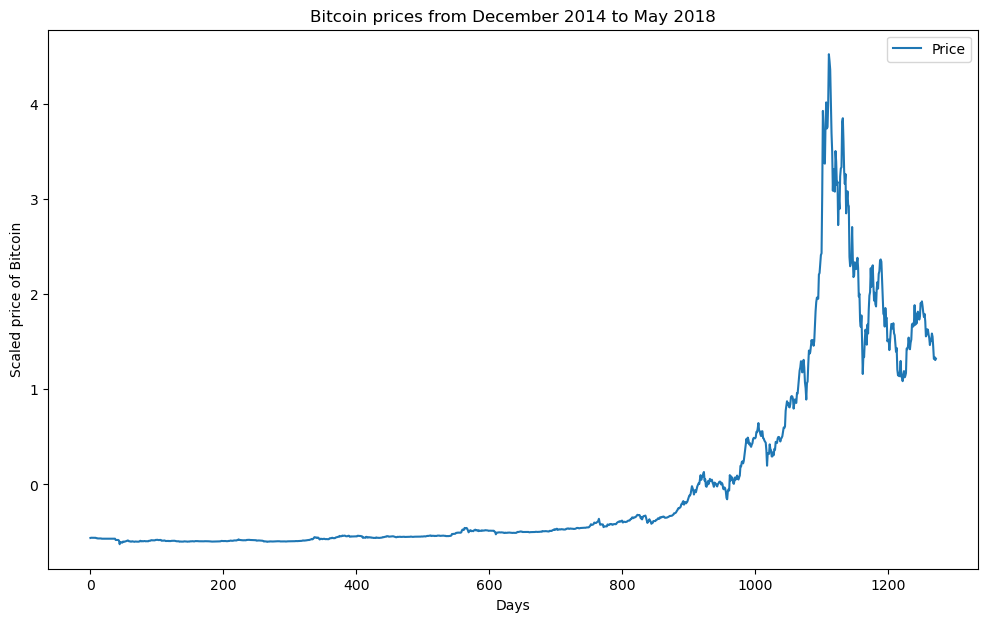

In [51]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

Preparação e Janelamento dos Dados

Neste trecho do código, estamos realizando o processo de janelamento dos dados, 
que é uma técnica essencial quando estamos trabalhando com redes LSTM para séries temporais. 
Abaixo está um detalhamento do que o código faz:

In [54]:
window_size = 20

def window_data(data):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

X, y = window_data(scaled_data)



X_train  = np.array(X[:900])
y_train = np.array(y[:900])

X_val = np.array(X[900:1000])
y_val = np.array(y[900:1000])

X_test = np.array(X[1000:])
y_test = np.array(y[1000:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_val.shape))
print("y_test size: {}".format(y_val.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (900, 20, 1)
y_train size: (900, 1)
X_test size: (100, 20, 1)
y_test size: (100, 1)
X_test size: (253, 20, 1)
y_test size: (253, 1)


Construção e Otimização do Modelo LSTM com Busca em Grade

Neste trecho de código, é definido um modelo LSTM para prever séries temporais e, 
em seguida, é aplicada a técnica de busca em grade (Grid Search) para otimizar seus parâmetros. 
A estrutura LSTM é definida através da função build_model, e diversos valores possíveis para parâmetros 
como tamanho do lote (batch_size), número de neurônios na camada oculta (hidden_layer) e 
taxa de aprendizado (learning_rate) são especificados no dicionário param_grid. 
A busca em grade, então, treina o modelo com várias combinações desses parâmetros para encontrar 
a configuração que fornece o melhor desempenho no conjunto de validação.


Construção e Otimização do Modelo LSTM com Busca em Grade

Neste trecho de código, é definido um modelo LSTM para prever séries temporais e, 
em seguida, é aplicada a técnica de busca em grade (Grid Search) para otimizar seus parâmetros. 
A estrutura LSTM é definida através da função build_model, e diversos valores possíveis para parâmetros 
como tamanho do lote (batch_size), número de neurônios na camada oculta (hidden_layer) e 
taxa de aprendizado (learning_rate) são especificados no dicionário param_grid. 
A busca em grade, então, treina o modelo com várias combinações desses parâmetros para encontrar 
a configuração que fornece o melhor desempenho no conjunto de validação.

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model(batch_size, hidden_layer, learning_rate):
    model = Sequential()
    model.add(LSTM(hidden_layer, batch_input_shape=(batch_size, window_size, 1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer)
    
    return model

param_grid = {
    'batch_size': [32, 64, 128],
    'hidden_layer': [32, 64, 128, 256, 512],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [10]
}

model = KerasRegressor(build_fn=build_model)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, return_train_score=True)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Imprimindo os melhores resultados
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")




C:\Users\juliana_oikawa\AppData\Local\Temp\2\ipykernel_6340\2292497009.py:34: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model)


Epoch 1/10
19/19 [==============================] - 6s 83ms/step - loss: 0.0562 - val_loss: 0.0688
Epoch 2/10
19/19 [==============================] - 0s 23ms/step - loss: 0.0054 - val_loss: 0.0571
Epoch 3/10
19/19 [==============================] - 0s 25ms/step - loss: 0.0023 - val_loss: 0.0547
Epoch 4/10
19/19 [==============================] - 0s 21ms/step - loss: 0.0016 - val_loss: 0.0489
Epoch 5/10
19/19 [==============================] - 0s 23ms/step - loss: 0.0014 - val_loss: 0.0434
Epoch 6/10
19/19 [==============================] - 0s 24ms/step - loss: 0.0012 - val_loss: 0.0383
Epoch 7/10
19/19 [==============================] - 0s 23ms/step - loss: 0.0010 - val_loss: 0.0336
Epoch 8/10
19/19 [==============================] - 0s 22ms/step - loss: 8.2718e-04 - val_loss: 0.0295
Epoch 9/10
19/19 [==============================] - 0s 24ms/step - loss: 6.8176e-04 - val_loss: 0.0256
Epoch 10/10
19/19 [==============================] - 0s 8ms/step - loss: 5.1220e-04
Epoch 1/10
19/19 

Epoch 2/10
19/19 [==============================] - 0s 20ms/step - loss: 0.0189 - val_loss: 0.4179
Epoch 3/10
19/19 [==============================] - 0s 20ms/step - loss: 0.0114 - val_loss: 0.2122
Epoch 4/10
19/19 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0491
Epoch 5/10
19/19 [==============================] - 0s 20ms/step - loss: 6.1417e-04 - val_loss: 0.0182
Epoch 6/10
19/19 [==============================] - 0s 19ms/step - loss: 2.2613e-04 - val_loss: 0.0150
Epoch 7/10
19/19 [==============================] - 0s 23ms/step - loss: 1.2137e-04 - val_loss: 0.0131
Epoch 8/10
19/19 [==============================] - 0s 20ms/step - loss: 8.5484e-05 - val_loss: 0.0125
Epoch 9/10
19/19 [==============================] - 0s 20ms/step - loss: 8.1539e-05 - val_loss: 0.0123
Epoch 10/10
19/19 [==============================] - 0s 7ms/step - loss: 6.5565e-05
Epoch 1/10
19/19 [==============================] - 6s 74ms/step - loss: 0.4264 - val_loss: 0.9454
Epoch

Epoch 3/10
19/19 [==============================] - 1s 30ms/step - loss: 6.7457e-04 - val_loss: 0.1198
Epoch 4/10
19/19 [==============================] - 1s 30ms/step - loss: 3.8256e-04 - val_loss: 0.1174
Epoch 5/10
19/19 [==============================] - 1s 30ms/step - loss: 3.4978e-04 - val_loss: 0.1128
Epoch 6/10
19/19 [==============================] - 1s 28ms/step - loss: 3.3097e-04 - val_loss: 0.1091
Epoch 7/10
19/19 [==============================] - 1s 31ms/step - loss: 3.1113e-04 - val_loss: 0.1046
Epoch 8/10
19/19 [==============================] - 1s 27ms/step - loss: 2.9725e-04 - val_loss: 0.0997
Epoch 9/10
19/19 [==============================] - 1s 30ms/step - loss: 2.8521e-04 - val_loss: 0.0936
Epoch 10/10
19/19 [==============================] - 0s 11ms/step - loss: 2.6228e-04
Epoch 1/10
19/19 [==============================] - 6s 85ms/step - loss: 1.8864 - val_loss: 0.3345
Epoch 2/10
19/19 [==============================] - 1s 31ms/step - loss: 0.0165 - val_loss: 0.4

Epoch 4/10
19/19 [==============================] - 1s 65ms/step - loss: 0.0025 - val_loss: 0.0273
Epoch 5/10
19/19 [==============================] - 1s 60ms/step - loss: 7.6193e-04 - val_loss: 0.0453
Epoch 6/10
19/19 [==============================] - 1s 62ms/step - loss: 1.9222e-04 - val_loss: 0.0112
Epoch 7/10
19/19 [==============================] - 1s 61ms/step - loss: 1.6688e-04 - val_loss: 0.0146
Epoch 8/10
19/19 [==============================] - 1s 54ms/step - loss: 1.8660e-04 - val_loss: 0.0207
Epoch 9/10
19/19 [==============================] - 1s 68ms/step - loss: 1.5071e-04 - val_loss: 0.0116
Epoch 10/10
19/19 [==============================] - 1s 25ms/step - loss: 1.2621e-04
Epoch 1/10
19/19 [==============================] - 8s 131ms/step - loss: 0.0315 - val_loss: 0.0668
Epoch 2/10
19/19 [==============================] - 1s 66ms/step - loss: 0.0034 - val_loss: 0.0408
Epoch 3/10
19/19 [==============================] - 1s 55ms/step - loss: 0.0012 - val_loss: 0.0051
Epo

19/19 [==============================] - 2s 131ms/step - loss: 4.7401e-04 - val_loss: 0.0093
Epoch 6/10
19/19 [==============================] - 2s 130ms/step - loss: 3.1313e-04 - val_loss: 0.0071
Epoch 7/10
19/19 [==============================] - 2s 129ms/step - loss: 2.4236e-04 - val_loss: 0.0062
Epoch 8/10
19/19 [==============================] - 2s 131ms/step - loss: 2.1522e-04 - val_loss: 0.0060
Epoch 9/10
19/19 [==============================] - 3s 132ms/step - loss: 2.0123e-04 - val_loss: 0.0059
Epoch 10/10
19/19 [==============================] - 1s 50ms/step - loss: 2.0657e-04
Epoch 1/10
19/19 [==============================] - 8s 187ms/step - loss: 0.0378 - val_loss: 0.0270
Epoch 2/10
19/19 [==============================] - 2s 127ms/step - loss: 0.0019 - val_loss: 0.0284
Epoch 3/10
19/19 [==============================] - 2s 127ms/step - loss: 3.4153e-04 - val_loss: 0.0287
Epoch 4/10
19/19 [==============================] - 2s 129ms/step - loss: 1.2013e-04 - val_loss: 0.028

19/19 [==============================] - 2s 126ms/step - loss: 0.0016 - val_loss: 0.6312
Epoch 7/10
19/19 [==============================] - 2s 130ms/step - loss: 0.0014 - val_loss: 0.6101
Epoch 8/10
19/19 [==============================] - 2s 128ms/step - loss: 0.0015 - val_loss: 0.6227
Epoch 9/10
19/19 [==============================] - 2s 129ms/step - loss: 0.0015 - val_loss: 0.6576
Epoch 10/10
19/19 [==============================] - 1s 50ms/step - loss: 0.0014
Epoch 1/10
19/19 [==============================] - 13s 473ms/step - loss: 0.0202 - val_loss: 0.0189
Epoch 2/10
19/19 [==============================] - 8s 396ms/step - loss: 0.0013 - val_loss: 0.0142
Epoch 3/10
19/19 [==============================] - 8s 399ms/step - loss: 6.3580e-04 - val_loss: 0.0097
Epoch 4/10
19/19 [==============================] - 7s 391ms/step - loss: 3.8703e-04 - val_loss: 0.0062
Epoch 5/10
19/19 [==============================] - 8s 404ms/step - loss: 2.4437e-04 - val_loss: 0.0052
Epoch 6/10
19/19 

Epoch 7/10
19/19 [==============================] - 8s 405ms/step - loss: 0.0104 - val_loss: 0.1712
Epoch 8/10
19/19 [==============================] - 8s 401ms/step - loss: 0.0109 - val_loss: 0.1117
Epoch 9/10
19/19 [==============================] - 8s 421ms/step - loss: 0.0074 - val_loss: 0.0253
Epoch 10/10
19/19 [==============================] - 2s 104ms/step - loss: 0.0168
Epoch 1/10
19/19 [==============================] - 14s 466ms/step - loss: 121.4166 - val_loss: 12.1102
Epoch 2/10
19/19 [==============================] - 8s 411ms/step - loss: 2.6703 - val_loss: 0.1168
Epoch 3/10
19/19 [==============================] - 8s 423ms/step - loss: 0.2602 - val_loss: 0.2638
Epoch 4/10
19/19 [==============================] - 8s 400ms/step - loss: 0.0440 - val_loss: 0.5375
Epoch 5/10
19/19 [==============================] - 8s 407ms/step - loss: 0.0148 - val_loss: 0.2698
Epoch 6/10
19/19 [==============================] - 8s 410ms/step - loss: 0.0113 - val_loss: 0.3381
Epoch 7/10
19/

Epoch 9/10
10/10 [==============================] - 0s 29ms/step - loss: 1.5773e-04 - val_loss: 0.0052
Epoch 10/10
10/10 [==============================] - 0s 11ms/step - loss: 1.4725e-04
Epoch 1/10
10/10 [==============================] - 6s 137ms/step - loss: 0.0680 - val_loss: 0.0722
Epoch 2/10
10/10 [==============================] - 0s 27ms/step - loss: 0.0061 - val_loss: 0.1089
Epoch 3/10
10/10 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.1043
Epoch 4/10
10/10 [==============================] - 0s 26ms/step - loss: 8.0570e-04 - val_loss: 0.1136
Epoch 5/10
10/10 [==============================] - 0s 27ms/step - loss: 4.8996e-04 - val_loss: 0.1100
Epoch 6/10
10/10 [==============================] - 0s 25ms/step - loss: 3.5535e-04 - val_loss: 0.1107
Epoch 7/10
10/10 [==============================] - 0s 26ms/step - loss: 3.0839e-04 - val_loss: 0.1090
Epoch 8/10
10/10 [==============================] - 0s 26ms/step - loss: 2.7958e-04 - val_loss: 0.1065

10/10 [==============================] - 0s 17ms/step - loss: 1.3811e-04
Epoch 1/10
10/10 [==============================] - 6s 156ms/step - loss: 0.0624 - val_loss: 0.0651
Epoch 2/10
10/10 [==============================] - 0s 46ms/step - loss: 0.0084 - val_loss: 0.0642
Epoch 3/10
10/10 [==============================] - 0s 47ms/step - loss: 0.0046 - val_loss: 0.0697
Epoch 4/10
10/10 [==============================] - 0s 49ms/step - loss: 0.0032 - val_loss: 0.0589
Epoch 5/10
10/10 [==============================] - 0s 45ms/step - loss: 0.0025 - val_loss: 0.0396
Epoch 6/10
10/10 [==============================] - 0s 49ms/step - loss: 0.0018 - val_loss: 0.0237
Epoch 7/10
10/10 [==============================] - 0s 48ms/step - loss: 9.9665e-04 - val_loss: 0.0090
Epoch 8/10
10/10 [==============================] - 0s 44ms/step - loss: 4.3795e-04 - val_loss: 0.0046
Epoch 9/10
10/10 [==============================] - 0s 44ms/step - loss: 1.6024e-04 - val_loss: 0.0105
Epoch 10/10
10/10 [====

10/10 [==============================] - 0s 34ms/step - loss: 5.9315e-04
Epoch 1/10
10/10 [==============================] - 6s 198ms/step - loss: 0.0855 - val_loss: 0.0428
Epoch 2/10
10/10 [==============================] - 1s 81ms/step - loss: 0.0076 - val_loss: 0.0396
Epoch 3/10
10/10 [==============================] - 1s 85ms/step - loss: 0.0035 - val_loss: 0.0379
Epoch 4/10
10/10 [==============================] - 1s 82ms/step - loss: 0.0023 - val_loss: 0.0348
Epoch 5/10
10/10 [==============================] - 1s 84ms/step - loss: 0.0018 - val_loss: 0.0319
Epoch 6/10
10/10 [==============================] - 1s 86ms/step - loss: 0.0013 - val_loss: 0.0288
Epoch 7/10
10/10 [==============================] - 1s 82ms/step - loss: 0.0011 - val_loss: 0.0255
Epoch 8/10
10/10 [==============================] - 1s 82ms/step - loss: 9.2660e-04 - val_loss: 0.0227
Epoch 9/10
10/10 [==============================] - 1s 88ms/step - loss: 7.9058e-04 - val_loss: 0.0199
Epoch 10/10
10/10 [========

Epoch 2/10
10/10 [==============================] - 1s 79ms/step - loss: 0.0476 - val_loss: 0.7359
Epoch 3/10
10/10 [==============================] - 1s 76ms/step - loss: 0.0188 - val_loss: 0.3510
Epoch 4/10
10/10 [==============================] - 1s 78ms/step - loss: 0.0082 - val_loss: 0.5311
Epoch 5/10
10/10 [==============================] - 1s 78ms/step - loss: 0.0026 - val_loss: 0.5785
Epoch 6/10
10/10 [==============================] - 1s 79ms/step - loss: 0.0016 - val_loss: 0.5218
Epoch 7/10
10/10 [==============================] - 1s 80ms/step - loss: 0.0014 - val_loss: 0.5034
Epoch 8/10
10/10 [==============================] - 1s 78ms/step - loss: 0.0014 - val_loss: 0.4762
Epoch 9/10
10/10 [==============================] - 1s 81ms/step - loss: 0.0018 - val_loss: 0.4947
Epoch 10/10
10/10 [==============================] - 0s 30ms/step - loss: 0.0012
Epoch 1/10
10/10 [==============================] - 7s 281ms/step - loss: 0.0414 - val_loss: 0.0246
Epoch 2/10
10/10 [=========

10/10 [==============================] - 2s 177ms/step - loss: 0.1085 - val_loss: 0.3956
Epoch 4/10
10/10 [==============================] - 2s 172ms/step - loss: 0.0253 - val_loss: 0.4891
Epoch 5/10
10/10 [==============================] - 2s 173ms/step - loss: 0.0144 - val_loss: 0.4551
Epoch 6/10
10/10 [==============================] - 2s 177ms/step - loss: 0.0131 - val_loss: 0.4352
Epoch 7/10
10/10 [==============================] - 2s 170ms/step - loss: 0.0133 - val_loss: 0.4163
Epoch 8/10
10/10 [==============================] - 2s 174ms/step - loss: 0.0127 - val_loss: 0.3894
Epoch 9/10
10/10 [==============================] - 2s 176ms/step - loss: 0.0114 - val_loss: 0.3542
Epoch 10/10
10/10 [==============================] - 1s 67ms/step - loss: 0.0112
Epoch 1/10
10/10 [==============================] - 7s 279ms/step - loss: 93.2376 - val_loss: 1.6336
Epoch 2/10
10/10 [==============================] - 2s 170ms/step - loss: 4.6991 - val_loss: 1.6763
Epoch 3/10
10/10 [===========

10/10 [==============================] - 6s 563ms/step - loss: 0.0334 - val_loss: 0.4333
Epoch 5/10
10/10 [==============================] - 6s 609ms/step - loss: 0.0222 - val_loss: 0.5354
Epoch 6/10
10/10 [==============================] - 6s 552ms/step - loss: 0.0189 - val_loss: 0.5303
Epoch 7/10
10/10 [==============================] - 6s 559ms/step - loss: 0.0185 - val_loss: 0.4922
Epoch 8/10
10/10 [==============================] - 6s 561ms/step - loss: 0.0180 - val_loss: 0.5356
Epoch 9/10
10/10 [==============================] - 6s 557ms/step - loss: 0.0178 - val_loss: 0.5055
Epoch 10/10
10/10 [==============================] - 2s 164ms/step - loss: 0.0177
Epoch 1/10
10/10 [==============================] - 14s 682ms/step - loss: 4.2529 - val_loss: 0.5718
Epoch 2/10
10/10 [==============================] - 5s 552ms/step - loss: 1.6221 - val_loss: 0.8332
Epoch 3/10
10/10 [==============================] - 6s 587ms/step - loss: 0.1717 - val_loss: 1.0536
Epoch 4/10
10/10 [==========

Epoch 7/10
5/5 [==============================] - 0s 40ms/step - loss: 0.0020 - val_loss: 0.0563
Epoch 8/10
5/5 [==============================] - 0s 46ms/step - loss: 0.0024 - val_loss: 0.0571
Epoch 9/10
5/5 [==============================] - 0s 45ms/step - loss: 7.3582e-04 - val_loss: 0.0585
Epoch 10/10
5/5 [==============================] - 0s 17ms/step - loss: 5.3264e-04
Epoch 1/10
5/5 [==============================] - 6s 292ms/step - loss: 0.0545 - val_loss: 0.0509
Epoch 2/10
5/5 [==============================] - 0s 51ms/step - loss: 0.0091 - val_loss: 0.0568
Epoch 3/10
5/5 [==============================] - 0s 53ms/step - loss: 0.0044 - val_loss: 0.0596
Epoch 4/10
5/5 [==============================] - 0s 51ms/step - loss: 0.0026 - val_loss: 0.0493
Epoch 5/10
5/5 [==============================] - 0s 41ms/step - loss: 0.0029 - val_loss: 0.0495
Epoch 6/10
5/5 [==============================] - 0s 55ms/step - loss: 0.0022 - val_loss: 0.0433
Epoch 7/10
5/5 [=======================

5/5 [==============================] - 0s 29ms/step - loss: 0.0014
Epoch 1/10
5/5 [==============================] - 7s 333ms/step - loss: 0.1605 - val_loss: 0.0581
Epoch 2/10
5/5 [==============================] - 0s 80ms/step - loss: 0.0243 - val_loss: 0.0508
Epoch 3/10
5/5 [==============================] - 0s 86ms/step - loss: 0.0179 - val_loss: 0.0471
Epoch 4/10
5/5 [==============================] - 0s 77ms/step - loss: 0.0062 - val_loss: 0.0428
Epoch 5/10
5/5 [==============================] - 0s 93ms/step - loss: 0.0042 - val_loss: 0.0414
Epoch 6/10
5/5 [==============================] - 0s 83ms/step - loss: 0.0060 - val_loss: 0.0405
Epoch 7/10
5/5 [==============================] - 0s 76ms/step - loss: 0.0026 - val_loss: 0.0402
Epoch 8/10
5/5 [==============================] - 0s 78ms/step - loss: 0.0021 - val_loss: 0.0394
Epoch 9/10
5/5 [==============================] - 0s 86ms/step - loss: 0.0024 - val_loss: 0.0377
Epoch 10/10
5/5 [==============================] - 0s 30ms/

5/5 [==============================] - 0s 88ms/step - loss: 0.0998 - val_loss: 1.8123
Epoch 4/10
5/5 [==============================] - 0s 79ms/step - loss: 0.0353 - val_loss: 3.1431
Epoch 5/10
5/5 [==============================] - 0s 100ms/step - loss: 0.0165 - val_loss: 1.7363
Epoch 6/10
5/5 [==============================] - 0s 78ms/step - loss: 0.0163 - val_loss: 2.6198
Epoch 7/10
5/5 [==============================] - 0s 77ms/step - loss: 0.0125 - val_loss: 2.1719
Epoch 8/10
5/5 [==============================] - 0s 91ms/step - loss: 0.0065 - val_loss: 1.8899
Epoch 9/10
5/5 [==============================] - 0s 71ms/step - loss: 0.0048 - val_loss: 2.2118
Epoch 10/10
5/5 [==============================] - 0s 27ms/step - loss: 0.0039
Epoch 1/10
5/5 [==============================] - 7s 378ms/step - loss: 0.1037 - val_loss: 0.0434
Epoch 2/10
5/5 [==============================] - 1s 122ms/step - loss: 0.0160 - val_loss: 0.0364
Epoch 3/10
5/5 [==============================] - 1s 122

5/5 [==============================] - 1s 150ms/step - loss: 0.0812 - val_loss: 1.0229
Epoch 7/10
5/5 [==============================] - 1s 129ms/step - loss: 0.0736 - val_loss: 0.5108
Epoch 8/10
5/5 [==============================] - 1s 130ms/step - loss: 0.0383 - val_loss: 0.2651
Epoch 9/10
5/5 [==============================] - 1s 132ms/step - loss: 0.0306 - val_loss: 0.3286
Epoch 10/10
5/5 [==============================] - 0s 42ms/step - loss: 0.0129
Epoch 1/10
5/5 [==============================] - 6s 379ms/step - loss: 27.3260 - val_loss: 4.2407
Epoch 2/10
5/5 [==============================] - 1s 128ms/step - loss: 8.9780 - val_loss: 0.4984
Epoch 3/10
5/5 [==============================] - 1s 124ms/step - loss: 3.2344 - val_loss: 5.0516
Epoch 4/10
5/5 [==============================] - 1s 121ms/step - loss: 1.2510 - val_loss: 1.0992
Epoch 5/10
5/5 [==============================] - 1s 127ms/step - loss: 1.2979 - val_loss: 2.7557
Epoch 6/10
5/5 [==============================] -

5/5 [==============================] - 1s 280ms/step - loss: 0.0059 - val_loss: 0.0717
Epoch 10/10
5/5 [==============================] - 1s 97ms/step - loss: 0.0047
Epoch 1/10
5/5 [==============================] - 7s 582ms/step - loss: 0.5396 - val_loss: 0.1580
Epoch 2/10
5/5 [==============================] - 1s 292ms/step - loss: 0.2032 - val_loss: 0.1527
Epoch 3/10
5/5 [==============================] - 1s 293ms/step - loss: 0.0215 - val_loss: 0.1070
Epoch 4/10
5/5 [==============================] - 1s 310ms/step - loss: 0.0161 - val_loss: 0.1946
Epoch 5/10
5/5 [==============================] - 1s 289ms/step - loss: 0.0063 - val_loss: 0.2540
Epoch 6/10
5/5 [==============================] - 1s 302ms/step - loss: 0.0023 - val_loss: 0.1661
Epoch 7/10
5/5 [==============================] - 1s 298ms/step - loss: 0.0052 - val_loss: 0.2158
Epoch 8/10
5/5 [==============================] - 1s 286ms/step - loss: 0.0014 - val_loss: 0.7336
Epoch 9/10
5/5 [==============================] - 

5/5 [==============================] - 2s 296ms/step - loss: 1.7486e-04
Epoch 1/10
5/5 [==============================] - 10s 1s/step - loss: 9.4446 - val_loss: 4.4872
Epoch 2/10
5/5 [==============================] - 5s 950ms/step - loss: 3.0352 - val_loss: 0.7749
Epoch 3/10
5/5 [==============================] - 5s 931ms/step - loss: 1.1366 - val_loss: 4.9580
Epoch 4/10
5/5 [==============================] - 4s 868ms/step - loss: 1.0978 - val_loss: 0.0644
Epoch 5/10
5/5 [==============================] - 5s 925ms/step - loss: 0.8402 - val_loss: 0.3221
Epoch 6/10
5/5 [==============================] - 4s 889ms/step - loss: 0.3177 - val_loss: 1.6130
Epoch 7/10
5/5 [==============================] - 4s 881ms/step - loss: 0.1635 - val_loss: 0.0581
Epoch 8/10
5/5 [==============================] - 5s 939ms/step - loss: 0.1672 - val_loss: 0.9513
Epoch 9/10
5/5 [==============================] - 5s 930ms/step - loss: 0.1196 - val_loss: 0.4392
Epoch 10/10
5/5 [==============================]

Visualização da Evolução do MSE Durante a Busca em Grade

Neste segmento, é realizada a visualização dos resultados da otimização de parâmetros usando o GridSearch. 
O objetivo é avaliar a evolução do Erro Quadrático Médio (MSE) ao longo das diferentes configurações testadas 
pelo GridSearch. As médias e desvios padrão do MSE para os conjuntos de treinamento e validação são armazenados 
e, posteriormente, plotados em um gráfico. As áreas sombreadas no gráfico representam a variação (uma vez o desvio padrão)
em torno das médias, proporcionando uma visualização da consistência e da estabilidade das métricas para cada 
configuração testada.

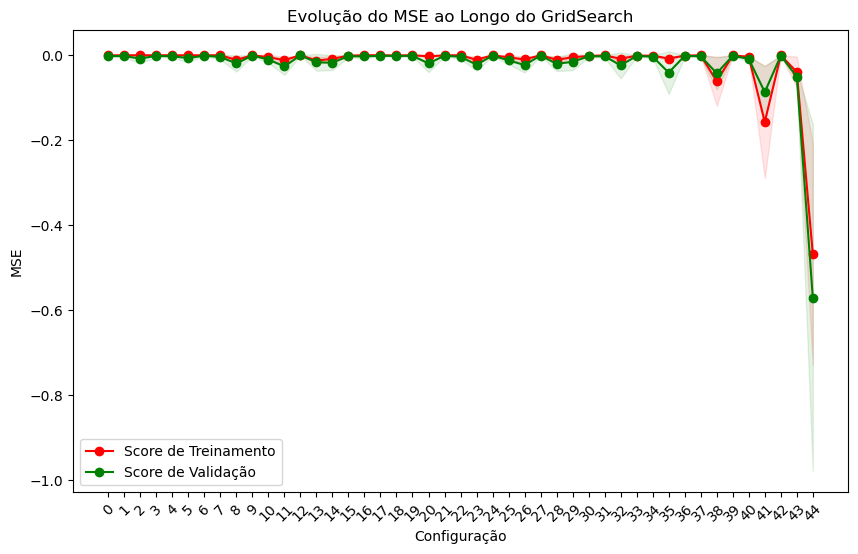

In [56]:
# Visualizar a evolução das métricas
import matplotlib.pyplot as plt

train_scores_mean = grid_result.cv_results_["mean_train_score"]
train_scores_std = grid_result.cv_results_["std_train_score"]
test_scores_mean = grid_result.cv_results_["mean_test_score"]
test_scores_std = grid_result.cv_results_["std_test_score"]

plt.figure(figsize=(10, 6))
plt.title("Evolução do MSE ao Longo do GridSearch")
plt.xlabel("Configuração")
plt.ylabel("MSE")
plt.fill_between(range(len(train_scores_mean)), train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(range(len(test_scores_mean)), test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_scores_mean, 'o-', color="r", label="Score de Treinamento")
plt.plot(test_scores_mean, 'o-', color="g", label="Score de Validação")
plt.xticks(range(len(train_scores_mean)), rotation=45)
plt.legend(loc="best")
plt.show()

In [57]:
grid_result.best_params_

{'batch_size': 32, 'epochs': 10, 'hidden_layer': 512, 'learning_rate': 0.001}


Avaliação e Visualização das Métricas de Desempenho do Modelo

Nesta seção, o modelo treinado é usado para fazer previsões no conjunto de teste e várias 
métricas de desempenho são calculadas para avaliar sua precisão. Especificamente, 
o Erro Quadrático Médio (MSE), a Raiz do Erro Quadrático Médio (RMSE) e a 
Similaridade Cosseno são computados para comparar as previsões com os valores reais. 
Após o cálculo, essas métricas são visualizadas em um gráfico de barras, facilitando a 
interpretação e a comparação dos resultados. O gráfico apresenta cada métrica em uma barra distinta, 
com valores precisos indicados acima de cada barra para clareza adicional.

8/8 [==============================] - 2s 114ms/step
MSE: 0.08622948563884573
RMSE: 0.2936485750669425
COSINE: 0.9898784603435453


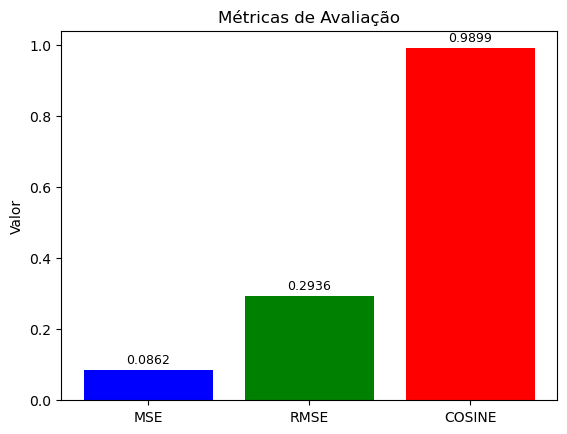

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine
import numpy as np

y_pred = grid_result.predict(X_test).flatten()

y_test_1d = y_test.flatten()

mse = mean_squared_error(y_test_1d, y_pred)
print(f"MSE: {mse}")

rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

cosine_similarity = 1 - cosine(y_test_1d, y_pred)
print(f"COSINE: {cosine_similarity}")

import matplotlib.pyplot as plt

metrics_names = ['MSE', 'RMSE', 'COSINE']
metrics_values = [mse, rmse, cosine_similarity]

plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red'])

plt.title("Métricas de Avaliação")
plt.ylabel('Valor')
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, "%.4f" % v, ha='center', va='bottom', fontsize=9)

plt.show()


"""
Comparação Visual de Previsões e Valores Reais ao Longo do Tempo

Neste segmento, o modelo otimizado é utilizado para realizar previsões no conjunto de validação. 
Em seguida, os resultados dessas previsões são plotados juntamente com os valores reais de preço 
do Bitcoin ao longo do tempo, permitindo uma visualização direta do desempenho do modelo. A figura 
gerada fornece uma visão abrangente, mostrando tanto os dados originais, quanto os segmentos de treinamento, 
validação e teste. Além disso, são delineadas tanto as previsões quanto os valores reais para os conjuntos de 
validação e teste, facilitando a comparação. A legenda, cores diferenciadas e títulos adicionam clareza ao gráfico,
tornando a interpretação dos resultados mais intuitiva.
"""

4/4 [==============================] - 0s 69ms/step


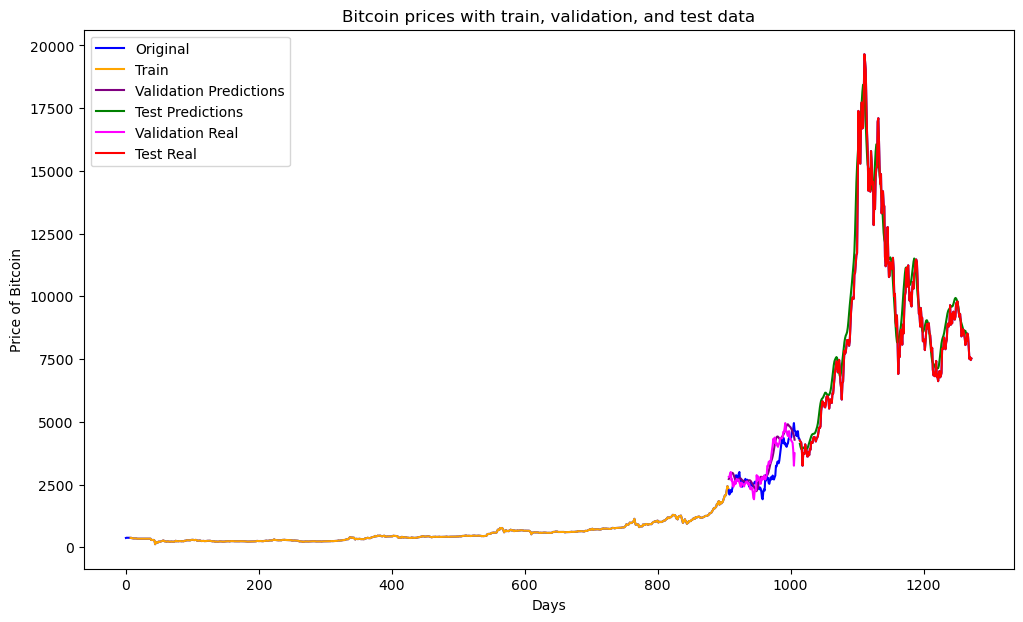

In [59]:

best_model = grid_result.best_estimator_.model
y_val_pred = best_model.predict(X_val)

plt.figure(figsize=(12,7))

plt.plot(scaler.inverse_transform(scaled_data[:val_start_point]), color='blue', label='Original')

plt.plot(range(7, len(X_train) + 7), scaler.inverse_transform(scaled_data[7:len(X_train)+7]), color='orange', label='Train')

val_start_point = len(X_train) + 7
val_end_point = val_start_point + len(y_val_pred)
plt.plot(range(val_start_point, val_end_point), scaler.inverse_transform(y_val_pred.reshape(-1,1)), color='purple', label='Validation Predictions')

test_start_point = val_end_point + 7
test_end_point = test_start_point + len(y_pred)
plt.plot(range(test_start_point, test_end_point), scaler.inverse_transform(y_pred.reshape(-1,1)), color='green', label='Test Predictions')

plt.plot(range(val_start_point, val_end_point), scaler.inverse_transform(y_val.reshape(-1,1)), color='magenta', label='Validation Real')

plt.plot(range(test_start_point, len(scaled_data)), scaler.inverse_transform(scaled_data[test_start_point:]), color='red', label='Test Real')

plt.title('Bitcoin prices with train, validation, and test data')
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.legend()
plt.show()
